In [1]:
# default_exp utils

# Utils

> Basic utilities with few dependencies.

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [18]:
# export
from collections.abc import Iterable, Mapping
from functools import partial
import io
import inspect
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import random
import requests
import torch
import warnings

from htools import flatten, ifnone, save, load

At training time, we will typically want to put the model and the current mini batch on the GPU. When developing on a CPU, a GPU isn't available, so we define a variable that will automatically find the right device. This goes in utils rather than core to avoid circular imports with the callbacks module.

In [ ]:
# export
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DEVICE

device(type='cpu')

In [ ]:
# export
def reproducible(seed=1, verbose=True):
    if verbose: print('Setting seeds for reproducible training.')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# export
def gpu_setup(make_reproducible=True, seed=1, verbose=1):
    if make_reproducible: reproducible(seed, verbose)
    if not torch.cuda.is_available(): warnings.warn('Cuda not available.')
    if DEVICE.type != 'cuda': 
        print(DEVICE)
        warnings.warn('Incendio device is not cuda.')

In [ ]:
# export
def hasarg(func, arg):
    """Checks if a function has a given argument.
    Works with args and kwargs as well if you exclude the
    stars. See example below.

    Parameters
    ----------
    func: function
    arg: str
        Name of argument to look for.

    Returns
    -------
    bool

    Example
    -------
    def foo(a, b=6, *args):
        return

    >>> hasarg(foo, 'b')
    True

    >>> hasarg(foo, 'args')
    True

    >>> hasarg(foo, 'c')
    False
    """
    return arg in inspect.signature(func).parameters

In [ ]:
# export
def quick_stats(x, digits=3):
    """Quick wrapper to get mean and standard deviation of a tensor.

    Parameters
    ----------
    x: torch.Tensor
    digits: int
        Number of digits to round mean and standard deviation to.

    Returns
    -------
    tuple[float]
    """
    return round(x.mean().item(), digits), round(x.std().item(), digits)

In [ ]:
# export
def concat(*args, dim=-1):
    """Wrapper to torch.cat which accepts tensors as non-keyword
    arguments rather than requiring them to be wrapped in a list.
    This can be useful if we've built some generalized functionality
    where parameters must be passed in a consistent manner.
    
    Parameters
    ----------
    args: torch.tensor
        Multiple tensors to concatenate.
    dim: int
        Dimension to concatenate on (last dimension by default).
        
    Returns
    -------
    torch.tensor
    """
    return torch.cat(args, dim=dim)

In [ ]:
# export
def weighted_avg(*args, weights):
    """Compute a weighted average of multiple tensors.
    
    Parameters
    ----------
    args: torch.tensor
        Multiple tensors with the same dtype and shape that you want to 
        average.
    weights: list
        Ints or floats to weight each input tensor. The length of this list
        must match the number of tensors passed in: the first weight will be
        multiplied by the first tensor, the second weight by the second 
        tensor, etc. If your weights don't sum to 1, they will be normalized 
        automatically.
        
    Returns
    -------
    torch.tensor: Same dtype and shape as each of the input tensors.
    """
    weights = torch.tensor(weights)
    total = weights.sum().float()
    if total != 1: weights = weights / total
    res = torch.stack(args)
    weights_shape = [-1 if i == 0 else 1 for i, _ in enumerate(range(res.ndim))]
    return torch.mean(res * weights.view(*weights_shape), axis=0)

In [6]:
# export
def identity(x):
    """Temporarily copied from htools.
    
    Returns the input argument. Sometimes it is convenient to have this if
    we sometimes apply a function to an item: rather than defining a None
    variable, sometimes setting it to a function, then checking if it's None
    every time we're about to call it, we can set the default as identity and
    safely call it without checking.
    
    Parameters
    ----------
    x: any
    
    Returns
    -------
    x: Unchanged input.
    """
    return x

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# export
def tensor_dict_diffs(d1, d2):
    """Compare two dictionaries of tensors. The two dicts must have the 
    same keys.
    
    Parameters
    ----------
    d1: dict[any: torch.Tensor]
    d2: dict[any: torch.Tensor]
    
    Returns
    -------
    list: Returns the keys where tensors differ for d1 and d2. 
    """
    assert d1.keys() == d2.keys()
    res = []
    for k, v in d1.items():
        if not torch.eq(v, d2[k]).all():
            res.append(k)
    return res

In [ ]:
# export
def find_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector.
    From
    https://forums.fast.ai/t/gpu-memory-not-being-freed-after-training-is-over/10265/8
    with some minor reformatting.
    
    Parameters
    ----------
    gpu_only: bool
        If True, only find tensors that are on the GPU.
        
    Returns
    -------
    None: Output is printed to stdout.
    """
    def pretty_size(size):
        """Pretty prints a torch.Size object."""
        assert(isinstance(size, torch.Size))
        return " × ".join(map(str, size))

    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and (not gpu_only or obj.is_cuda):
                print(f'{type(obj).__name__}: {"GPU" if obj.is_cuda else ""}',
                      "pinned" if obj.is_pinned else "",
                      pretty_size(obj.size()))
                total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print(
                        f'{type(obj).__name__} → {type(obj.data).__name__}',
                        'GPU' if obj.is_cuda else '',
                        'pinned' if obj.data.is_pinned else '',
                        'grad' if obj.requires_grad else '',
                        'volatile' if obj.volatile else '',
                        pretty_size(obj.data.size())
                    )
                    total_size += obj.data.numel()
        except Exception:
            pass
    print("Total size:", total_size)

In [ ]:
# export
def inverse_sigmoid(y):
    """Use to determine the bias initializer for the final linear layer of
    model.
    
    Parameters
    ----------
    x: float
        Value between 0 and 1 (e.g. the proportion of the training data that
        are postives).
        
    Returns
    -------
    float: Inverse sigmoid of input.
        I.E. if y=sigmoid(x), inverse_sigmoid(y)=x.
    """
    return np.log(y / (1-y))

In [ ]:
# export
def init_bias_constant_(layer, value=None, target_pct=None):
    """Helper to initialize a layer's bias term to a constant. This is
    particularly useful for the final layer of a binary classifier where it's
    often helpful to intialize it to the value that, when passed through a 
    sigmoid activation, is equal to the percent of your dataset belonging to
    the majority class. This reduces the chance that the first epoch or so
    will be spent simply learning a bias term, and has two benefits:
    
    1. May reduce training time slightly.
    2. The beginning of training can be deceptively important - a messy first
    couple epochs can have long-lasting repercussions. This is often hard to
    identify without in-depth digging into model weights so it often goes
    unnoticed. 
    
    Parameters
    ----------
    layer: nn.Module
        The layer to initialize a bias for. This will often be the last layer
        of our network - we rarely need to initialize a constant bias 
        otherwise.
    value: float or None
        If provided, the bias will be initialized to this value.
    target_pct: float or None
        If provided, must be a float between 0 and 1.
        
    Returns
    -------
    None: The layer is updated in place.
    """
    assert bool(value is None) + bool(target_pct is None) == 1, \
        'Specify either `value` OR `target_pct`.'
    if target_pct is not None:
        assert 0 < target_pct < 1, \
        '`target_pct` must be in range (0, 1) (exclusive).'

    value = value or inverse_sigmoid(target_pct)
    with torch.no_grad():
        layer.bias.fill_(value)

In [ ]:
# export
def is_builtin(x, drop_callables=True):
    """Check if an object belongs to the Python standard library.
    
    Parameters
    ----------
    drop_callables: bool
        If True, we won't consider callables (classes/functions) to be builtin.
        Classes have class `type` and functions have class 
        `builtin_function_or_method`, both of which are builtins - however, 
        this is often not what we mean when we want to know if something is
        built in. Note: knowing the class alone is not enough to determine if
        the objects it creates are built-in; this may depend on the kwargs
        passed to its constructor. This will NOT check if a class was defined
        in the standard library.
    
    Returns
    -------
    bool: True if the object is built-in. If the object is list-like, each
    item will be checked as well the container. If the object is dict-like,
    each key AND value will be checked (you can always pass in d.keys() or 
    d.values() for more limited checking). Again, the container itself will
    be checked as well.
    """
    def _builtin(x, drop_callables):
        if callable(x) and drop_callables:
            return False
        return x.__class__.__module__ == 'builtins'
    
    builtin = partial(_builtin, drop_callables=drop_callables)
    # Check mapping before iterable because mappings are iterable.
    if isinstance(x, Mapping):
        return builtin(x) and all(builtin(o) for o in flatten(x.items()))
    elif isinstance(x, Iterable):
        return builtin(x) and all(builtin(o) for o in flatten(x))
    return builtin(x)

In [1]:
# export
def out_features(model): 
    """Try to extract number of output features from the last layer of a 
    model. This is often useful when building encoder-decoder models or 
    stacking encoders and classification heads. Not sure how airtight the 
    logic is here so use with caution.
    
    Parameters
    ----------
    model: nn.Module
        Model to examine.

    Returns
    -------
    int: Number of output features.
    """
    return [c.out_features for c in model.children() 
            if hasattr(c, 'out_features')][-1]

In [70]:
# export
def get_einops_image(path=None, as_tensor=True, channels_first=True, 
                     color=True):
    """Easily load the sample image einops uses for tutorials. Nice way to
    play around with tensor reshaping/transformation to make sure you're doing
    what you think you are. The file will be stored in a dir called 
    ~/.incendio.
    
    Parameters
    ----------
    path: None or str or Path
        If not None, this is the location to try to load the file from and to
        save it to if it's not already there. Otherwise, this defaults to
        ~/.incendio/einops.zip.
    as_tensor: bool
        Return tensor if True, np array if False.
    channels_first: bool
        Return with shape (bs, c, h, w) if True, (bs, h, w, c) if False. 
        Ignored if color=False.
        
    Returns
    -------
    torch.Tensor or np.ndarray
    """
    path = Path(ifnone(path, '~/.incendio/einops.zip')).expanduser()
    if not path.is_file():
        r = requests.get('https://github.com/arogozhnikov/einops/raw/master/'
                         'docs/resources/test_images.npy')
        r.raise_for_status()
        save(np.load(io.BytesIO(r.content)).astype(np.float32), path)
    array = load(path).astype(np.float32)
    if not color: array = array[..., 0]
    elif channels_first: array = array.transpose(0, 3, 1, 2)
    if as_tensor: array = torch.tensor(array)
    return array

In [71]:
img = get_einops_image()
img_bw = get_einops_image(color=False)
img.shape, img_bw.shape

Object loaded from /Users/hmamin/.incendio/einops.zip.
Object loaded from /Users/hmamin/.incendio/einops.zip.


(torch.Size([6, 3, 96, 96]), torch.Size([6, 96, 96]))

In [72]:
# export
def plot_img_batch(x, channels_first=True):
    """Plot batch of image tensors. Helpful for assessing operations on
    tensors, particularly when reshaping things with einops or equivalent ops
    (view, transpose, etc.).
    
    Parameters
    ----------
    x: torch.Tensor or np.array
        Shape (bs, h, w), (bs, c, h, w), or (bs, h, w, c). Often it's nice to
        use the tensor loaded by `get_einops_image` here.
    channels_first: bool
        Specify if your input x has channels before the spatial dimensions,
        e.g. True if x has shape (bs, c, h, w) and False if it has shape
        (bs, h, w, c). (Technically the batch dimension is always first, this
        just means first relative to the spatial dimensions.)
    """
    ndim = x.ndim
    assert ndim in {3, 4}, \
        'x ndim must be 3 or 4: (bs, h, w), (bs, c, h, w) or (bs, h, w, c)'

    if getattr(x, 'requires_grad', False): x = x.detach().numpy()
    fig, ax = plt.subplots(len(x), 1, figsize=(4, len(x)*2))
    cmap = 'gray' if ndim == 3 else None
    for i, (xi, axi) in enumerate(zip(x, ax.flatten())):
        if ndim == 4 and channels_first: xi = xi.permute(1, 2, 0)
        axi.imshow(xi, cmap=cmap)
        axi.set_title(f'Batch {i}')
        axi.set_xticks([], [])
        axi.set_yticks([], [])
    plt.tight_layout()
    plt.show()

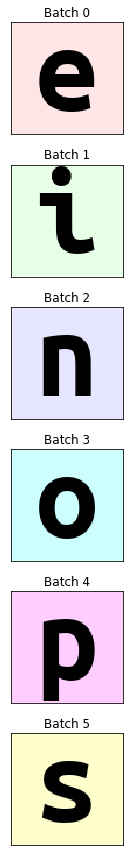

In [73]:
plot_img_batch(img)

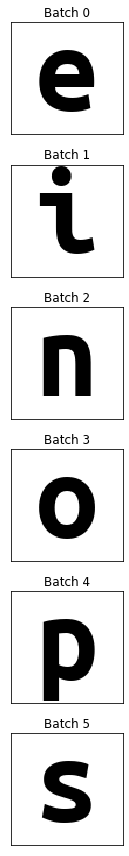

In [74]:
plot_img_batch(img_bw)